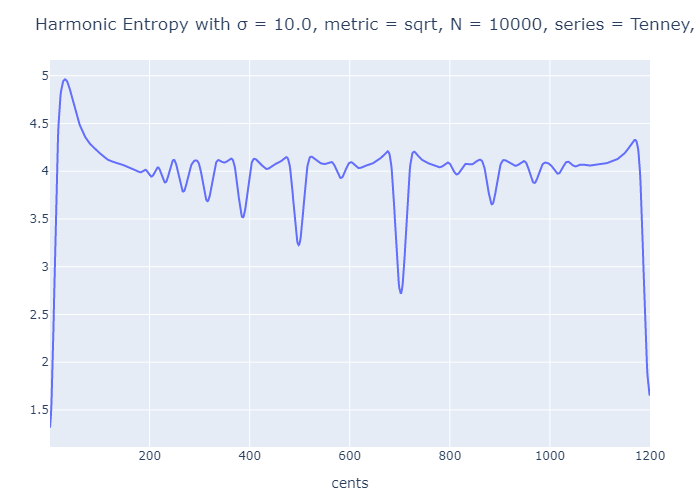

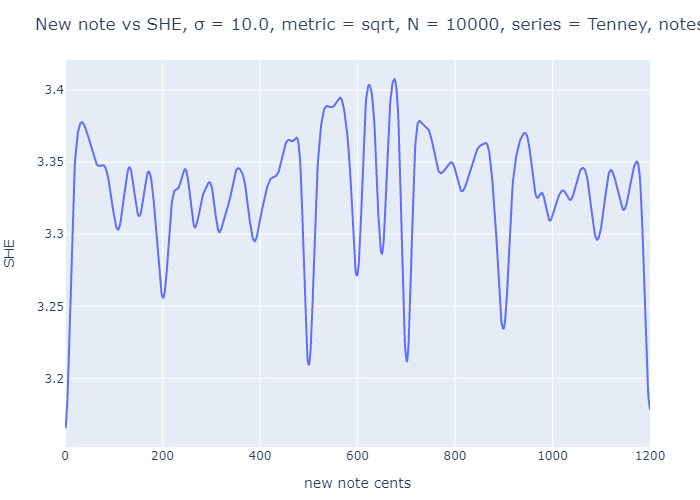

true

In [3]:
using PlotlyJS, NBInclude, Statistics, StatsBase

@nbinclude("Harmonic_Entropy.ipynb")

run_examples = true

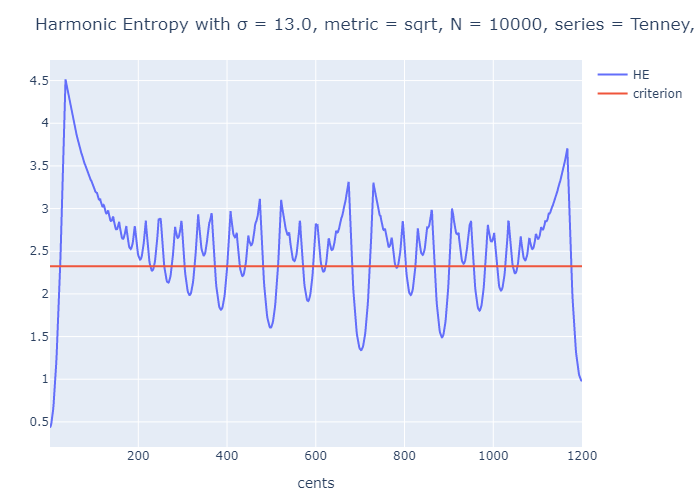

In [19]:
if run_examples
    σ = 13.
    metric = "sqrt" # "max" or "sqrt"
    N = 10000     #  100 - Farey or 10000 - Tenney
    series = "Tenney" # "Farey" or "Tenney"
    entropyType = "min" # "shannon" or "min"
    C = 1:1.0:1200

    layout = Layout(
        title="Harmonic Entropy with σ = $σ, metric = $metric, N = $N, series = $series, entropyType = $entropyType",
        xaxis_title = "cents",
    )
    
    HE_arr = HE(C, N, series, metric, σ, entropyType)
    trace1 = scatter(x=C, y=HE_arr, name="HE")
    #criterion = median(HE_arr)
    #criterion = mean(HE_arr)
    criterion = percentile(HE_arr, 30)
    trace2 = scatter(x=C, y=(HE_arr .* 0 .+ criterion), name="criterion")

    plot_data = [trace1, trace2]
    fig = plot(plot_data, layout)
    display(fig)
end

# PITCH MEMORY V2

it is simple and based on HE  
Problem: jump in HE between 1199 and 1200 cents: 1200->0 cents  
  
TODO:  
1) try using HE calculated for 2-4 octaves  
2) try Harmonic Min-Entropy (HME)

In [17]:
struct Note
    id::Int
    start::Float64
    duration::Float64
    octave::Int
    cents::Float64
end


struct NoteMemoryTrace
    start::Float64
    duration::Float64
    octave::Int
    cents::Float64
end


function findNotesMemoryTraces(
        notes::Vector{Note},
        endTime::Float64,
        HE_arr::Vector{Float64},
        C_step::Float64,
        criterion::Float64
        )::Vector{NoteMemoryTrace}
    notesMemoryTraces = NoteMemoryTrace[]

    for note in notes
        noteMemoryTraceDuration = endTime - note.start
        noteMemoryTraceMinDuration = min(note.duration, noteMemoryTraceDuration)

        for otherNote in notes
            if otherNote.id != note.id
                #if abs((note.octave*1200+note.cents) - (otherNote.octave*1200+otherNote.cents)) <= 1200 # EXPERIMENTAL
                    if (otherNote.start + otherNote.duration > note.start + note.duration) && 
                       (otherNote.start < (note.start + noteMemoryTraceDuration))
                        if HE_arr[min(Int(abs((note.octave*1200+note.cents) - (otherNote.octave*1200+otherNote.cents))%1200/C_step)+1, length(HE_arr))] > criterion
                            noteMemoryTraceDuration = max(noteMemoryTraceMinDuration, otherNote.start - note.start)
                        end
                    end
                #end
            end
        end

        noteMemoryTrace = NoteMemoryTrace(note.start, noteMemoryTraceDuration, note.octave, note.cents)
        push!(notesMemoryTraces, noteMemoryTrace)
    end

    return notesMemoryTraces
end



findNotesMemoryTraces (generic function with 1 method)

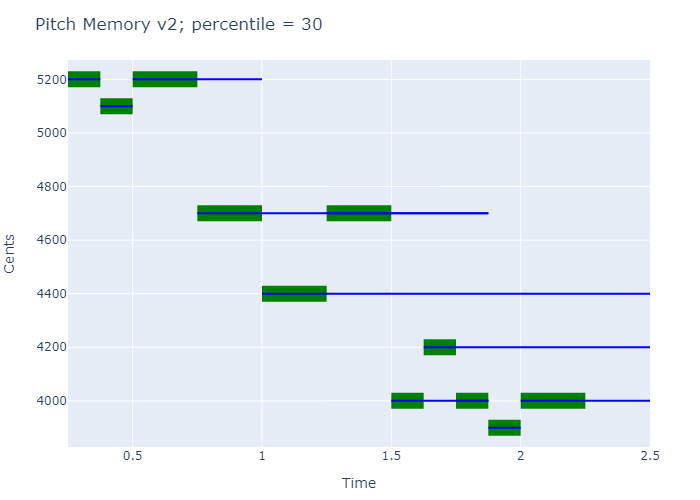

In [18]:
if run_examples
    σ = 13.
    metric = "sqrt" # "max" or "sqrt"
    N = 10000     #  100 - Farey or 10000 - Tenney
    series = "Tenney" # "Farey" or "Tenney"
    entropyType = "min" # "shannon" or "min"

    HE_arr = HE(C, N, series, metric, σ)
    perc = 30
    criterion = percentile(HE_arr, perc)

    endTime = 2.5
    notes = Note[]
    push!(notes, Note(1, 0.25, 0.125, 4, 400.))
    push!(notes, Note(2, 0.375, 0.125, 4, 300.))
    push!(notes, Note(3, 0.5, 0.25, 4, 400.))
    push!(notes, Note(4, 0.75, 0.25, 3, 1100.))
    push!(notes, Note(5, 1., 0.25, 3, 800.))
    push!(notes, Note(6, 1.25, 0.25, 3, 1100.))
    push!(notes, Note(7, 1.5, 0.125, 3, 400.))
    push!(notes, Note(8, 1.625, 0.125, 3, 600.))
    push!(notes, Note(9, 1.75, 0.125, 3, 400.))
    push!(notes, Note(10, 1.875, 0.125, 3, 300.))
    push!(notes, Note(11, 2., 0.25, 3, 400.))
    notesMemoryTraces = findNotesMemoryTraces(notes, endTime, HE_arr, 1., criterion)


    # visualization

    notes_traces = GenericTrace[]
    for note in notes
        push!(notes_traces, scatter(
            x = [note.start, note.start+note.duration],
            y = [note.octave*1200+note.cents, note.octave*1200+note.cents],
            mode="lines",
            line=attr(color="green", width=16)
        ))
    end
    for noteMemoryTrace in notesMemoryTraces
        push!(notes_traces, scatter(
            x = [noteMemoryTrace.start, noteMemoryTrace.start+noteMemoryTrace.duration],
            y = [noteMemoryTrace.octave*1200+noteMemoryTrace.cents, noteMemoryTrace.octave*1200+noteMemoryTrace.cents],
            mode="lines",
            line=attr(color="blue", width=2)
        ))
    end
    fig = plot(
        notes_traces,
        Layout(
            title="Pitch Memory v2; percentile = $(perc)",
            xaxis_title="Time",
            yaxis_title="Cents",
            showlegend=false
        )
    )
    display(fig)
end